In [1]:
from Data.IMDB import IMDB
from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
import dgl
import torch    

/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /storage/scratch/0994359/hetero-conv-matching/.venv2/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/

In [9]:
imdb = IMDB()
original_graph = imdb.load_graph(n_components=30)
device = "cuda:2"
original_graph = original_graph.to(device)

In [ ]:

num_nearest_init_neighbors_per_type = {"actortomovie": 50, "directortomovie": 50, "movietoactor":50, "movietodirector":50, "actor":50, "director":50, "movie":50}
from Projections.CCA import CCA
from Projections.JLRandom import JLRandomProjection
coarsener = HeteroRGCNCoarsener(original_graph, num_nearest_init_neighbors_per_type, batch_size=None, checkpoints=[0.9, 0.5, 0.3] ,folder_name="imdb_cca_pca_30",device=device,cca_cls=CCA, use_zscore=False, pairs_per_level=20,norm_p=1, approx_neigh=True, add_feat=True, use_out_degree=False) 

coarsener.init()

coarsener.summarize()

/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/dgl/transforms/functional.py:1366: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


actortomovie
directortomovie
movietoactor
movietodirector
step: 0, ratio: 1.0
step: 1, ratio: 0.9990530303030303
step: 2, ratio: 0.9981060606060606
step: 3, ratio: 0.9971590909090909
step: 4, ratio: 0.9962121212121212
step: 5, ratio: 0.9952651515151515
step: 6, ratio: 0.9943181818181818
step: 7, ratio: 0.9933712121212122
step: 8, ratio: 0.9924242424242424
step: 9, ratio: 0.9914772727272727
step: 10, ratio: 0.990530303030303
step: 11, ratio: 0.9895833333333334
step: 12, ratio: 0.9886363636363636
step: 13, ratio: 0.9876893939393939
step: 14, ratio: 0.9867424242424242
step: 15, ratio: 0.9857954545454546
step: 16, ratio: 0.9848484848484849
step: 17, ratio: 0.9839015151515151
step: 18, ratio: 0.9829545454545454
step: 19, ratio: 0.9820075757575758
step: 20, ratio: 0.9810606060606061
step: 21, ratio: 0.9801136363636364
step: 22, ratio: 0.9791666666666666
step: 23, ratio: 0.978219696969697
step: 24, ratio: 0.9772727272727273
step: 25, ratio: 0.9763257575757576
step: 26, ratio: 0.97537878787878

In [11]:
import torch
coarsend_graph = coarsener.summarized_graph

#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("movie")
coarsener.make_mask(mapping, "movie")

labels = coarsener.get_labels(mapping, "movie")
coarsend_graph.nodes["movie"].data["label"] = torch.tensor([labels[i] for i in range(len(labels)) ],  device=device) #,
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 


ratio 0.2997589531680441


In [ ]:
coarsend_graph.to()

device(type='cuda', index=2)

In [81]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Models.HeteroSGC import HeteroSGC
import importlib
from Models.HeteroSGC import HeteroSGCPaper
from Experiments.model_helper import run_experiments
from Experiments.plots import plot_bar, plot_line
orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,   HeteroSGCPaper, num_runs=1,
                                                  model_param={"hidden_dim": 64,"num_layers":8, "num_lins":1, "alpha":0.01},
                        optimizer_param={"lr": 0.001, "weight_decay": 5e-4}, epochs=200,eval_interval=1, target_node_type="movie", device="cuda:2")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]


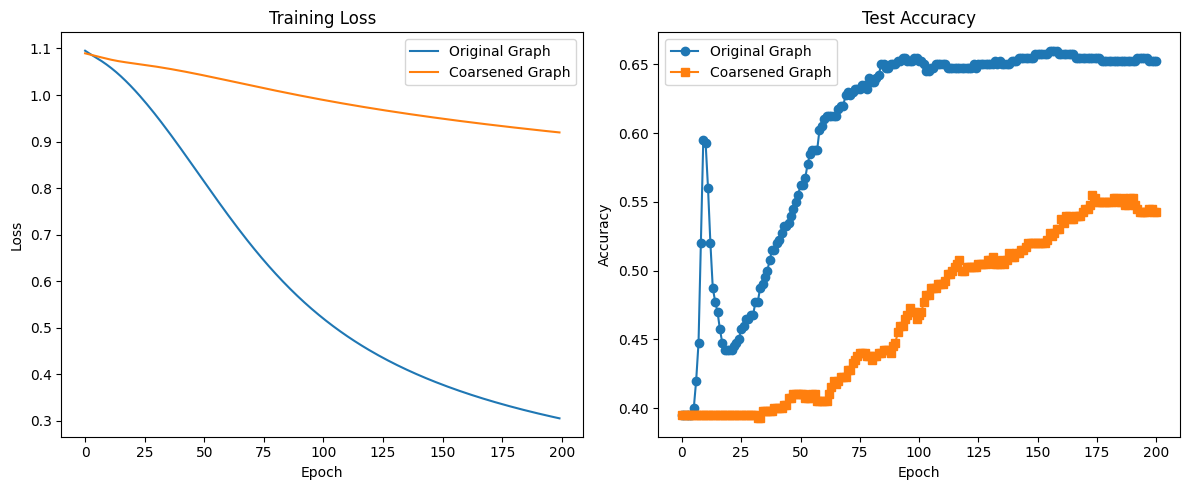

Final Performance Comparison:
Original Graph Accuracy: 0.6525
Coarsened Graph Accuracy: 0.5425

Original Graph Accuracy:
  Mean: 0.6525
  Std:  0.0000

Coarsened Graph Accuracy:
  Mean: 0.5425
  Std:  0.0000


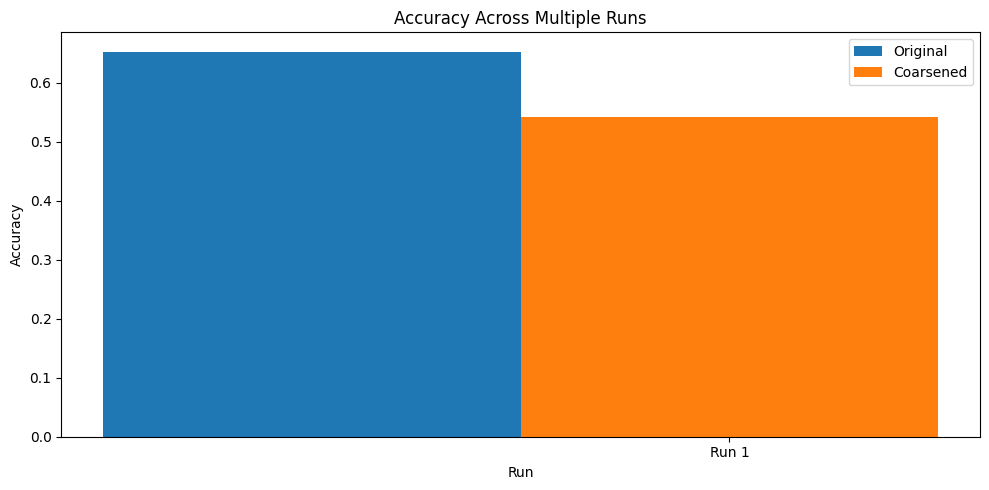

In [83]:
from Experiments.plots import plot_bar, plot_line

epochs = list(range(200))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
plot_bar(orig_short, coar_short)

TypeError: can't convert cuda:1 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

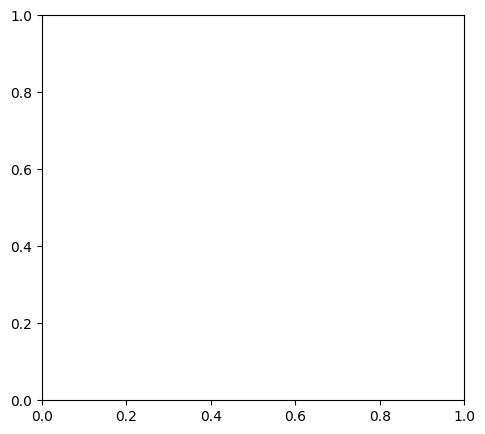

In [ ]:
epochs = torch.tensor(epochs, device=device)
